# In this work, only LoF mutations are used: calculate how many risk genes we can obtain with Nsample = 550

## Some ways have been used:

### Don't know any count information $=>$ use Poisson distribution

### Know counts from published data

### Use TADA method

### Use the trio package (for TDT)

I randomly chose 1000 genes, but it's probably better if choosing top 1000 genes from TADA results.

# Simulate counts from the Poisson distribution

## Some main steps:

nGene = Number of genes ( ~ 18500 genes)

. Randomly choose risk genes with prob = 1000/nGene

. Add relative risk into mutation rates of risk genes 

. Use Poisson distribution to sample all genes with new mutation rates

. Use Poisson test to obtain p values:

    At the $i^{th}$ gene, $p_value = P(X >= x_i| lambda = 2*Nsample*mu_i)$
 
 . Count genes with pvalues < 0.05
 
 Didn't adjust for all tests, with Nsample = 550: it's difficult to obtain significant values after adjustment


### We will use the Autism data from the TADA paper to have obtain some neccessary information

In [1]:
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)
pi <- 0.06
gamma.mean <- c(18, 5.4)
beta <- c(1, 0.5)
gamma.mean.est <- c(18, 5.4)
beta.est <- c(1, 0.5)

Nsample <- 550
mutLoF0 <- data$mut.rate*mu.frac[1] #(mu.frac[1]) # + mu.frac[2]) ##Mutation rates

In [2]:

nGene <- length(mutLoF0)

message("nGene: ", nGene)

Ntimes <- 100 ##Do this work Ntimes
geneCountforPower2 <- NULL
geneCountforPowerList2 <- list()
geneCountList <- list() ##Save all counts 


for (kk in 1:Ntimes) {

rrList <- seq(1, 30, by = 1)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
    geneCountTable <- matrix(0, ncol = length(rrList), nrow = nGene)

##Add relative risks to risk genes
piRG <- 1000/nGene ##Proportion of risk genes
z <- rbinom(nGene, 1, piRG)
table(z)/nGene
    
for (ii in 1:length(rrList)){
  RR <- rrList[ii]

  mutLoF <- mutLoF0

    #  mutLoF[z==1] <- mutLoF[z==1]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)
  mutLoF[1:1000] <- mutLoF[1:1000]*RR ##*rgamma(mutLoF[z==1], RR, rate = 1)

  geneCount <- rpois(nGene, 2*mutLoF*Nsample)

  
  
  poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)
  
  finalResult[, ii] <- poissonTest
      geneCountTable[, ii] <- geneCount

}

#apply(finalResult, 2, range)
t1 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))

geneCountList[[kk]] <- geneCountTable

    geneCountforPowerList2[[kk]] <- finalResult
    
geneCountforPower2 <- rbind(geneCountforPower2, t1)
}

gCount <- ceiling(apply(geneCountforPower2, 2, median))
            
            


nGene: 18735


In [3]:
allOut2 <- do.call(rbind, geneCountforPowerList2)



In [4]:
t2 <- t(apply(allOut2, 2, range)) ##Take a look at the smallest p of RR = 1
t2

2.730317e-06,1.000000e+00
4.649408e-06,1.000000e+00
9.176032e-07,1.000000e+00
3.622728e-07,1.000000e+00
6.507054e-07,1.000000e+00
3.096306e-07,1.000000e+00
8.612067e-07,1.000000e+00
2.633141e-07,1.000000e+00
7.728682e-07,1.000000e+00
5.264436e-07,1.000000e+00
7.028786e-08,1.000000e+00


In [5]:
alphaThreshold <- t2[1, 1]*10^2 ##Set a threshold using p value of RR = 1

outData <- do.call(rbind, lapply(geneCountforPowerList2, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
    
    gCount

[1] 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 2 1 1 2 2 2 2 2 2 3 3 3 3 4 4

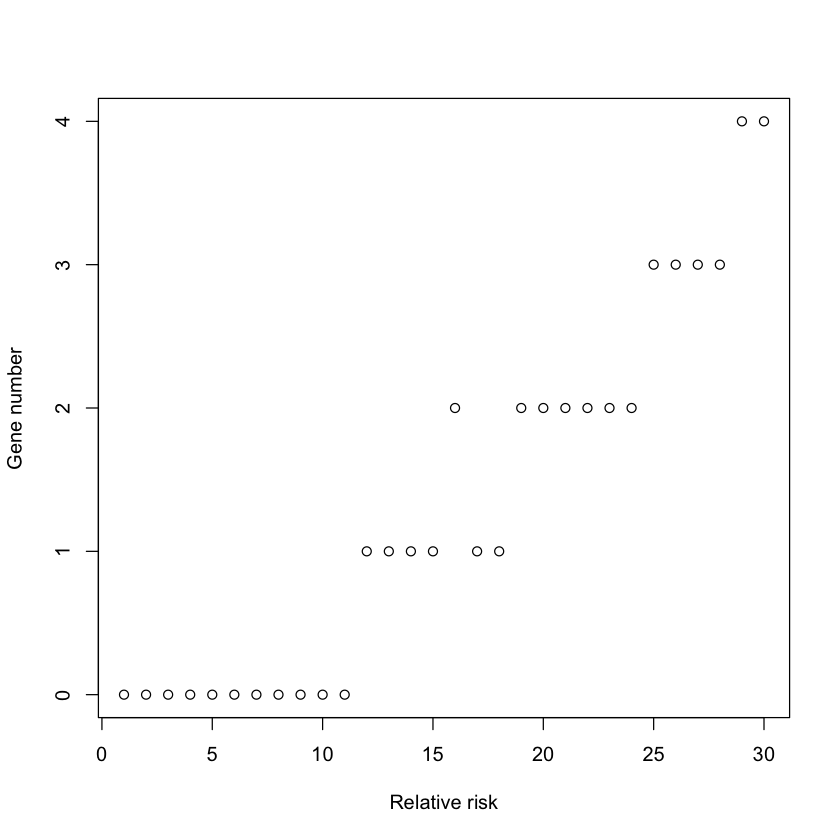

In [6]:

plot(rrList, gCount, xlab = 'Relative risk', ylab = 'Gene number')


### We will summarize how many counts for each RR below.
 

In [11]:
countSum <- lapply(geneCountList, function(x) apply(x, 2, sum))
countSum[[1]]


[1]  43  30  26  36  53  47  51  66  51  67  61  58  61  55  81  76  88  77  93
[20]  94  89 101  96  91  86  98  88  99 108 122

### Take a look at the predicted counts of de novos

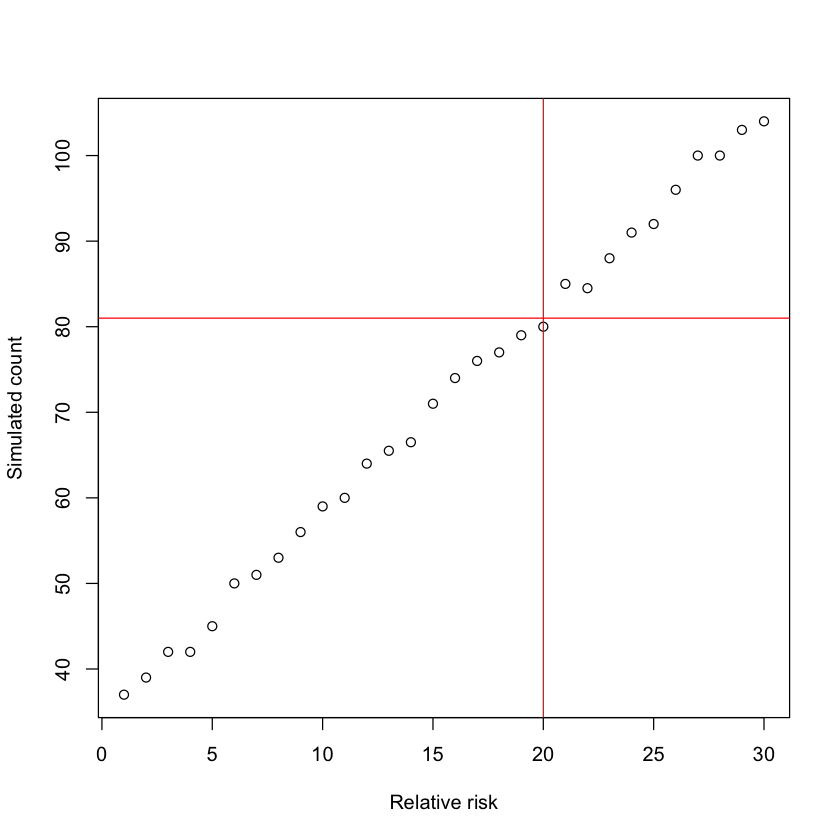

In [13]:
    Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nPredictedDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )
    
countSumAverage <- apply(do.call(rbind, countSum), 2, median)

    
    
    plot(rrList, countSumAverage, xlab = 'Relative risk', ylab = 'Simulated count')
    
    abline(v = 20, col = 'red')
    abline(h = nPredictedDenovo, col = 'red') ## Draw a line for predicted counts



### Now, will check how many recurrent genes are from simulated data?

In [14]:
recurrentCount <- lapply(geneCountList, function(x) apply(x, 2, function(y) length(y[y>1])))
recurrentCount[[1]]

recurrentCountAll <- do.call(rbind, recurrentCount)

apply(recurrentCountAll, 2, median) ##Not strong


[1] 0 0 0 0 0 0 0 1 0 0 0 4 0 1 0 2 0 2 2 1 1 2 4 2 1 1 2 4 5 4

[1] 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 1.0 1.5 1.0 1.0 2.0
[20] 1.5 2.0 2.0 2.0 2.0 2.0 3.0 3.0 3.0 3.0 3.0

# Use real counts from published data

## A little bit messy below, and not the results we want

## Use the data of AUT + EPI

Take a quick look at all information

#### DISEASE	NUM_INDIV

AUT	3985

CHD	362

EPI	356

ID	192

SCZ	1024

SIB_CONTROL	2049

### wc -l AUT+EPI.LoF.mut 

  637

(3985 AUT + 356 EPI) samples have 637 LoF mutations

#### Here, I randomly allocate counts to nGene, but counts should be allocated to the top 1000 genes


In [3]:
sum(data$dn.LoF)

[1] 308

In [24]:
Nsample_old <- 3985 + 356 ##There are 637 de novo mutations in this sample set
Nsample <- 550
Ncount_old <- 637
nDenovo <- ceiling(Nsample*Ncount_old/Nsample_old )

mutLoF0 <- data$mut.rate*(mu.frac[1]) # + mu.frac[2]) ##Mutation rates
nGene <- length(mutLoF)


geneCountforPower1 <- NULL
geneCountforPowerList1 <- list()
Ntimes <- 15 ##Do this work Ntimes

for (kk in 1:Ntimes) {
  
indexRiskGene <- sample(1:nGene, 1000)

rrList <- seq(1, 20, by = 3)
finalResult <- matrix(0, ncol = length(rrList), nrow = nGene)
##Add relative risks to risk genes
for (ii in 1:length(rrList)){
  RR <- rrList[ii]
  mutLoF <- mutLoF0
mutLoF[indexRiskGene] <- mutLoF[indexRiskGene]*RR

nMutLoF <- mutLoF/sum(mutLoF) ##Normalize mutation rates to 1
sum(nMutLoF)

##Randomly assign each de novo mutation (from nDenovo) to a gene with probabilies = normalized mutation rates
sDenovo <- table(sapply(1:nDenovo, function(x)
    sample(1:nGene, 1, prob = nMutLoF)))

sum(sDenovo)
geneCount <- numeric(nGene)
geneCount[as.numeric(names(sDenovo))] <- sDenovo ##Assign counts to specific genes


poissonTest <- ppois(geneCount - 1, lambda = 2*Nsample*mutLoF0, lower.tail = FALSE)

finalResult[, ii] <- poissonTest
}

apply(finalResult, 2, range)
t10 <- apply(finalResult, 2, function(x) length(x[x < 0.05]))
geneCountforPowerList1[[kk]] <- finalResult
geneCountforPower1 <- rbind(geneCountforPower1, t10)
}




In [25]:
allOut1 <- do.call(rbind, geneCountforPowerList1)


In [26]:
t1 <- t(apply(allOut1, 2, range)) ##Take a look at the smallest p of RR = 1
t1

1.343674e-06,1.000000e+00
1.700543e-06,1.000000e+00
4.66488e-07,1.00000e+00
1.087546e-07,1.000000e+00
6.345297e-08,1.000000e+00
4.806779e-09,1.000000e+00
3.547079e-07,1.000000e+00


In [29]:
alphaThreshold <- t1[1, 1]*10^3 ##Set a threshold using p value of RR = 1

outData1 <- do.call(rbind, lapply(geneCountforPowerList1, function(x)
  apply(x, 2, function(y)
    length(y[y < alphaThreshold]))))
gCount <- apply(outData1, 2, function(x) ceiling(median(x))) ###How many genes with this threshold?
    
    gCount

[1] 16 13 16 16 15 17 16

## TADA method

### Inside the TADA package, there is also a way to calculate gene numbers. We use this

Warning message:
In plot.xy(xy, type, ...): plot type 'both' will be truncated to first character

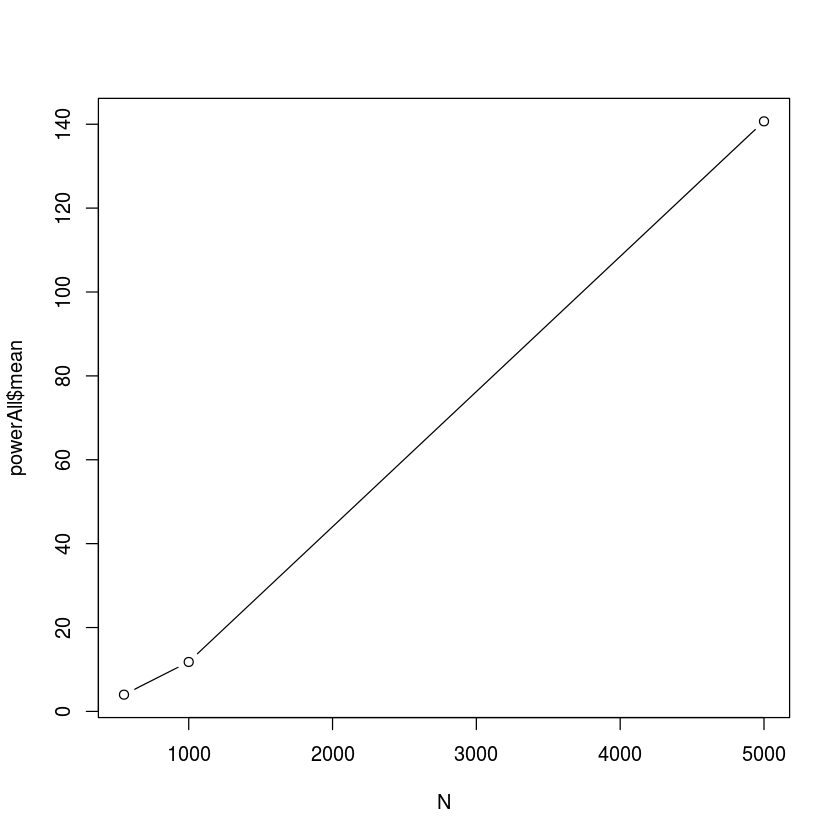

In [5]:
data <- read.csv("TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
source("TADA/TADA.R")

mu <- data$mut.rate
mu.frac <- c(0.074, 0.32)
pi <- 0.06
gamma.mean.dn <- c(18, 5.4)
beta.dn <- c(1, 0.5)
gamma.mean.CC <- c(2.3, 1.0)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.66, 0.6)
nu1 <- c(1947, 123)
rho0 <- c(0.66, 0.64)
nu0 <- c(1947, 123)
rho1.est <- c(0.1, 0.5)
nu1.est <- c(200, 100)
rho0.est <- c(0.1, 0.5)
nu0.est <- c(200, 100)
hyperpar.est <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1.est, nu1.est, rho0.est, nu0.est))


nr <- 10
rs <- numeric(nr)
N <- c(550, 1000, 5000) #1000*seq(0.5, 5, by = 0.5)
power.mean <- numeric(length(N))
power.sd <- numeric(length(N))
for (i in 1:length(N)) {
  N.curr <- list(dn=N[i], ca=N[i], cn=N[i])
  rs <- replicate(nr, eval.TADA(N.curr, mu, mu.frac, pi, gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0, hyperpar.est, FDR=0.1, tradeoff=TRUE)$M1)
  power.mean[i] <- mean(rs)
  power.sd[i] <- sd(rs)
}
power <- data.frame(mean=power.mean, sd=power.sd)

powerAll <- power
plot(N, powerAll$mean, type = 'both')


In [9]:
powerAll

,mean,sd
1,4,2.309401
2,11.8,3.705851
3,140.7,16.69364


# Use the trio package from the Bioconductor project

In [8]:
library("trio")

trio.power(maf = c(0.005), RR = 18.3, beta = 0.8, model = c("add", "dom"))
trio.power(maf = c(0.005), RR = 2.3, beta = 0.8, model = c("add", "dom"))



       Trio studies sample size calculation 

   Test          Model   MAF alpha   RR beta Trios
1  gTDT       additive 0.005 5e-08 18.3  0.8   481
2  gTDT       dominant 0.005 5e-08 18.3  0.8   500
3 Score       additive 0.005 5e-08 18.3  0.8   273
4 Score       dominant 0.005 5e-08 18.3  0.8   273
5  aTDT multiplicative 0.005 5e-08 18.3  0.8   273

       Trio studies sample size calculation 

   Test          Model   MAF alpha  RR beta Trios
1  gTDT       additive 0.005 5e-08 2.3  0.8  8052
2  gTDT       dominant 0.005 5e-08 2.3  0.8  8077
3 Score       additive 0.005 5e-08 2.3  0.8  7776
4 Score       dominant 0.005 5e-08 2.3  0.8  7799
5  aTDT multiplicative 0.005 5e-08 2.3  0.8  7776